In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
import pycbc.conversions as conv
import time
import emcee
import corner

from mpi4py import MPI
import glob


In [2]:
save_likelihoods = False

plotdir = 'power_law_m2_lim_hyper_param_plots/'

likelihood_dir = 'power_law_-3.5_5_100_m2_lim_likelihoods/'

mcmc_dir = 'mcmc/powerlaw_3.5_m2_lim/'

alpha_inj = -3.5
beta_inj = 0.0
mmin_inj = 5.0
mmax_inj = 60.

bias_index=1

import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
files = [f'powerlaw_3.5_lams_m2_lim/powerlaw_alpha_3.5_lam_0_1_Mc_0_9600.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
df_mc_raw = df_mc_raw[(df_mc_raw["m1"]/(1+df_mc_raw["z"])) <= 60.]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))

Total number of events: 9105


In [4]:
files = [f'powerlaw_3.5_lams_m2_lim/powerlaw_alpha_3.5_lam_0_1_eta_0_9600.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
df_eta_raw = df_eta_raw[(df_eta_raw["m1"]/(1+df_eta_raw["z"])) <= 60.]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 9105


In [5]:
# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

print(len(df_mc))
print(np.median(df_mc["Mc"]))

9105
20.590229726828472


In [6]:
def sample_m1_m2_events(df_mc, df_eta, biased=False, bias_index=19, injected=True):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)
    m2_mu_detections = df_mc["m2"] / (1+z)

    # compute variance of m1
    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m1_variance = m1_variance.values

    # compute variance of m2
    aux0=0.25*((((-1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
    aux2=(((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+aux2
    m2_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m2_variance = m2_variance.values

    # compute covariance of m1 and m2
    aux0=(0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*((sigMc**2)*(((1.+(1.*z))**2))))
    aux1=(-0.09*((1.+(-4.*eta))**2.))+((((1.+(-4.*eta))**1.)*(0.09+(-0.6*eta)))+(-1.*(eta**2)))
    aux2=((0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*(sigZ**2)))+(((1.+(-4.*eta))**-1.)*(aux1*((sigEta**2)*(((1.+(1.*z))**2)))))
    m1_m2_covariance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+((mchirp**2)*aux2)))
    m1_m2_covariance = m1_m2_covariance.values

    if biased:
        bias_mc = df_mc[f"bias_{bias_index}"]
        bias_eta = df_eta[f"bias_{bias_index}"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible
        # eta_biased = df_mc["eta"]+bias_eta

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        m2_mu_detections = conv.mass2_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    m1_mu_sampled = np.random.normal(m1_mu_detections, np.sqrt(m1_variance))
    m2_mu_sampled = np.random.normal(m2_mu_detections, np.sqrt(m2_variance))

    if injected:
        m1_mu_sampled = m1_mu_detections.values
        m2_mu_sampled = m2_mu_detections.values

    return m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance

In [7]:
def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A
    # return stats.norm.pdf(m1, loc=mu, scale=sigma)

def bivariate_normal_dist(m1, m2, mu1, mu2, cov):
    sig1 = np.sqrt(cov[0,0])
    sig2 = np.sqrt(cov[1,1])
    sig12 = cov[0,1]

    rho = sig12 / (sig1 * sig2)

    Z = ((m1-mu1)**2 / (sig1)**2) + ((m2-mu2)**2 / (sig2)**2) - ((2*rho*(m1-mu1)*(m2-mu2)) / (sig1*sig2))

    A = 2*np.pi * sig1 * sig2 * np.sqrt(1-(rho**2))

    return np.exp(-(Z / (2 * (1 - rho**2)))) / A

# MCMC

In [42]:
m1_min_int = 4.5
m1_max_int= 180.
n_m1_int= 800
n_m2_int= 300

N_events = 100
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:N_events], df_eta[:N_events], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

Ns = len(m1_mu_sampled)
Nt = Ns

m_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

posteriors_m2 = np.zeros((Nt, n_m1_int, n_m1_int))
for i in range(Nt):
    for j in range(n_m1_int):
        posteriors_m2[i,j] = bivariate_normal_dist(m_int_range[j], m_int_range, m1_mu_sampled[i], m2_mu_sampled[i], covariances[i])

In [9]:
# def lnprob_parallel_test(hyper):
#     alpha = hyper[0]
#     m1_min_pow = hyper[1]
#     m1_max_pow = hyper[2]
#     beta = beta_inj


#     # get number of processors and processor rank
#     comm = MPI.COMM_WORLD
#     size = comm.Get_size()
#     rank = comm.Get_rank()


#     count = Nt // size  # number of catchments for each process to analyze
#     remainder = Nt % size  # extra catchments if n is not a multiple of size

#     if rank < remainder:  # processes with rank < remainder analyze one extra catchment
#         start = rank * (count + 1)  # index of first catchment to analyze
#         stop = start + count + 1  # index of last catchment to analyze
#     else:
#         start = rank * count + remainder
#         stop = start + count

#     integrand_m2_local = np.zeros((stop-start, n_m1_int))
#     prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
#     prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)

#     for j in range(n_m1_int):
#         m2_int_range = np.linspace(m1_min_int, m_int_range[j], n_m2_int)
#         priors_m2 = power(m2_int_range, beta, m1_min_pow, m_int_range[j])

#         for i in range(start, stop):
#             posteriors_m2 = bivariate_normal_dist(m_int_range[j], m2_int_range, m1_mu_sampled[i], m2_mu_sampled[i], covariances[i])
#             integrand_m2_local[i,j] = integrate.trapezoid(priors_m2 * posteriors_m2, m2_int_range)   

#     # send results to rank 0
#     if rank > 0:
#         comm.Send(integrand_m2_local, dest=0)  # send results to process 0
#     else:
#         integrand_m2_combined = np.copy(integrand_m2_local)  # initialize final results with results from process 0
#         for i in range(1, size):  # determine the size of the array to be received from each process
#             if i < remainder:
#                 rank_size = count + 1
#             else:
#                 rank_size = count
#             tmp = np.empty((rank_size, n_m1_int), dtype=np.float)  # create empty array to receive results
#             print(tmp.shape)
#             comm.Recv(tmp, source=i)  # receive results from the process
#             integrand_m2_combined = np.vstack((integrand_m2_combined, tmp))  # add the received results to the final results
        
  
#         integrands = prior_m1 * integrand_m2_combined
#         integrals = integrate.trapezoid(integrands, m_int_range, axis=1)

#         print("done with integrals")
#         integrals = integrals[integrals!=0]
        
#         return np.sum(np.log(integrals))


In [ ]:
def lnprob_parallel(hyper, index_range):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    beta = beta_inj

    start = index_range[0]
    stop = index_range[1]
    N_posteriors = stop-start

    integrand_m2_local = np.zeros((N_posteriors, n_m1_int))
    prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
    prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)

    for j in range(n_m1_int):
        m2_int_range = np.linspace(m1_min_int, m_int_range[j], n_m2_int)
        priors_m2 = power(m2_int_range, beta, m1_min_pow, m_int_range[j])

        for i in range(N_posteriors):
            index = start+i
            posteriors_m2 = bivariate_normal_dist(m_int_range[j], m2_int_range, m1_mu_sampled[index], m2_mu_sampled[index], covariances[index])
            integrand_m2_local[i,j] = integrate.trapezoid(priors_m2 * posteriors_m2, m2_int_range)

        integrands = prior_m1 * integrand_m2_local
        integrals = integrate.trapezoid(integrands, m_int_range, axis=1)

        integrals = integrals[integrals!=0]

        return np.sum(np.log(integrals))


In [7]:
N_events = 100
N_parallel = 3

# determine how many events will be handled by each processor
size = N_events // N_parallel
remainder = N_events % N_parallel

# split N_events into separate ranges for each processor
indices = []
for i in range(N_parallel):
    indices.append([i*size, (i+1)*size])

# add the remaining events to the last processpr
indices[-1][1] = indices[-1][1]+remainder

print(indices)

33
1
[[0, 33], [33, 66], [66, 100]]


In [ ]:
from mpi4py.futures import MPIPoolExecutor
import numpy as np

def calc_squares(range_tuple):
        return range_tuple**2


if __name__ == '__main__':
    size = 3
    subranges = []

    for i in range(size):
        subranges.append(np.linspace(i*size, (i+1)*size, size))

    executor = MPIPoolExecutor()
    prime_sets = executor.map(calc_squares, subranges)
    executor.shutdown()

    for result in prime_sets:
        print(result)

In [44]:
def lnprob(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    beta = beta_inj

    integrand_m2 = np.zeros((Nt, n_m1_int))
    prior_m1 = power(m_int_range, alpha, m1_min_pow, m1_max_pow)
    prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m_int_range)

    for j in range(n_m1_int):
        m2_int_range = np.linspace(m1_min_int, m_int_range[j], n_m2_int)
        priors_m2 = power(m2_int_range, beta, m1_min_pow, m_int_range[j])
        for i in range(Nt):
            posteriors_m2 = bivariate_normal_dist(m_int_range[j], m2_int_range, m1_mu_sampled[i], m2_mu_sampled[i], covariances[i])
            integrand_m2[i,j] = integrate.trapezoid(priors_m2 * posteriors_m2, m2_int_range)   


    integrands = prior_m1 * integrand_m2
    integrals = integrate.trapezoid(integrands, m_int_range, axis=1)
    integrals = integrals[integrals!=0]
    
    return np.sum(np.log(integrals))


In [12]:
def population_posterior(hyper):

    # set only the 'mcmc_params' from the hyper array,
    # leave everything else to 'injected' value.
    hyper_mcmc = [alpha_inj, mmin_inj, mmax_inj]

    for i, mcmc_param in enumerate(mcmc_params):
        hyper_mcmc[mcmc_param] = hyper[i]

    alpha = hyper_mcmc[0]
    m1_min = hyper_mcmc[1]
    m1_max = hyper_mcmc[2]


    if (alpha>-1.0) or (alpha<-5.0):
        return -np.inf
    if (m1_min>5.5) or (m1_min<4.5):
        return -np.inf
    if (m1_max>200.0) or (m1_max<40.0):
        return -np.inf
    # if (beta>1.0) or (beta<-2.5):
    #     return -np.inf

    else:
        return lnprob(hyper_mcmc)

In [14]:
mcmc_params_list = ['alpha', 'm1_min', 'm1_max']
truths_all=[alpha_inj, mmin_inj, mmax_inj]
priors_mcmc_low_all = [-4.2, 4.98, 55.0]
priors_mcmc_high_all = [-3.8, 5.02, 65.0]

labels_all=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$"]

# set which parameters to run MCMC for
mcmc_params = [0,1] 


priors_mcmc_low = []
priors_mcmc_high = []
truths = []
labels = []

for mcmc_param in mcmc_params:
    priors_mcmc_low.append(priors_mcmc_low_all[mcmc_param])
    priors_mcmc_high.append(priors_mcmc_high_all[mcmc_param])
    truths.append(truths_all[mcmc_param])
    labels.append(labels_all[mcmc_param])

In [45]:
hyper_test = [-3.5, 4.97]

start = time.time()
print(population_posterior(hyper_test))
end = time.time()

print(f"Time: {end-start:.5f} s")

-302.3730643607408
Time: 1.93133 s


In [6]:
mcmc_params_p0 = [-3.5, 5.0, 60.0]
diffs = [0.1, 0.05, 5.0]
priors_mcmc_low_all = [x-y for x, y in zip(mcmc_params_p0, diffs)]
priors_mcmc_high_all = [x+y for x, y in zip(mcmc_params_p0, diffs)]

[-3.4, 5.05, 65.0]

In [14]:
fname = 'mcmc_'
for i in mcmc_params:
    fname += f'{mcmc_params_list[i]}_'

mcmc_file = likelihood_dir + fname + f'N_{N_events}.h5'
reset_mcmc = True

print(mcmc_file)

power_law_-3.5_5_100_m2_lim_likelihoods/mcmc_alpha_m1_min_N_100.h5


In [15]:
ndim, nwalkers = len(mcmc_params), 2*len(mcmc_params)+1

backend = emcee.backends.HDFBackend(mcmc_file)

if reset_mcmc:
    backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, backend=backend)
p0 = np.random.uniform(low=priors_mcmc_low, high=priors_mcmc_high, size=(nwalkers,ndim))

burnin=5

In [16]:
# # burn-in sampler:
# state = sampler.run_mcmc(p0, burnin, progress=True)
# sampler.reset()

In [17]:
N_MCMC = 10

# explore parameter space:
state = sampler.run_mcmc(p0, N_MCMC, progress=True)

100%|██████████| 10/10 [02:48<00:00, 16.88s/it]


In [18]:
# get flat results:
flat_samples = sampler.get_chain(discard=burnin, flat=True)

In [20]:
# Read samples from backend file
reader = emcee.backends.HDFBackend(mcmc_file)
flat_samples = reader.get_chain(discard=burnin, flat=True)

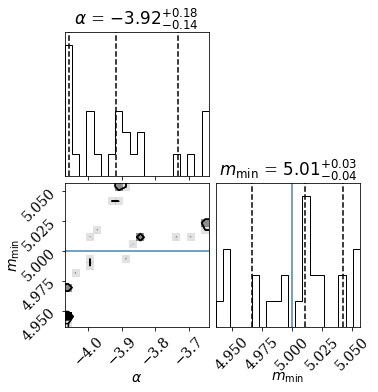

In [21]:
fig = corner.corner(flat_samples, truths=truths,\
                    labels=labels,\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True)
# plt.savefig(plotdir + f"3D_ N_MCMC_{N_MCMC}.pdf")

In [ ]:
# samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# alpha_mcmc, mmin_mcmc, mmax_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                              zip(*np.percentile(samples, [16, 50, 84],
#                                                 axis=0)))
# print(alpha_mcmc)
# print(mmin_mcmc)
# print(mmax_mcmc)

# Multiprocessing test

In [22]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


In [23]:
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, pool=pool, backend=backend)
    start = time.time()
    sampler.run_mcmc(p0, N_MCMC, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 10/10 [01:14<00:00,  7.47s/it]

Multiprocessing took 81.3 seconds


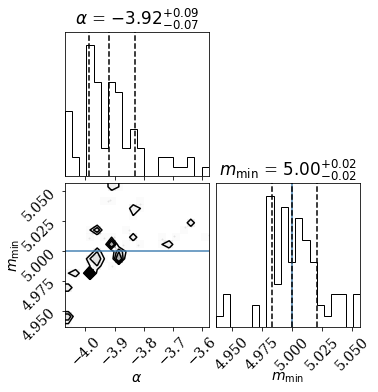

In [24]:
# get flat results:
flat_samples = sampler.get_chain(discard=burnin, flat=True)
fig = corner.corner(flat_samples, truths=truths,\
                    labels=labels,\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True)

In [25]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


In [27]:
mpi_time = !mpiexec -n {ncpu} python run_mcmc_powerlaw.py


^C


In [110]:
# Read samples from backend file
reader = emcee.backends.HDFBackend(mcmc_file)
flat_samples = reader.get_chain(discard=burnin, flat=True)

fig = corner.corner(flat_samples, truths=truths,\
                    labels=labels,\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True)

['/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars',
 '  lnpdiff = f + nlp - state.log_prob[j]',
 '19.36760711669922']

# Read MCMC files from Cluster

In [3]:
# set which parameters to run MCMC for
mcmc_params = [0,1,2] 
N_events = 9000
N_MCMC = 2000
burnin = 0

In [4]:
mcmc_params_list = ['alpha', 'm1_min', 'm1_max']
truths_all=[alpha_inj, mmin_inj, mmax_inj]
priors_mcmc_low_all = [-4.2, 4.98, 55.0]
priors_mcmc_high_all = [-3.8, 5.02, 65.0]

labels_all=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$"]

truths = []
labels = []

for mcmc_param in mcmc_params:
    truths.append(truths_all[mcmc_param])
    labels.append(labels_all[mcmc_param])
    
fname = 'mcmc_'
for i in mcmc_params:
    fname += f'{mcmc_params_list[i]}_'

mcmc_file = mcmc_dir + fname + f'N_events_{N_events}_N_MCMC_{N_MCMC}.h5'


print(mcmc_file)

mcmc/powerlaw_3.5_m2_lim/mcmc_alpha_m1_min_m1_max_N_events_9000_N_MCMC_2000.h5


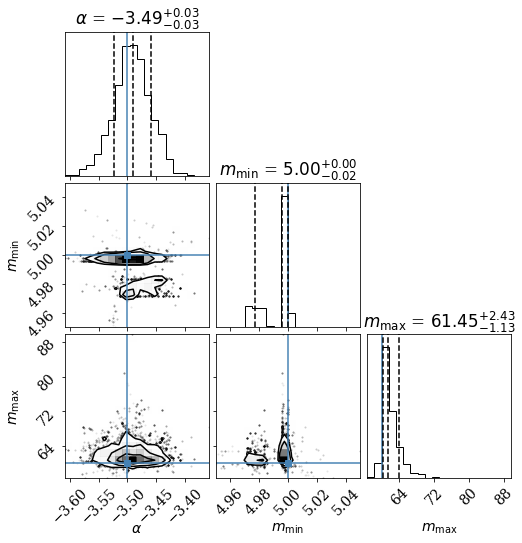

In [5]:
# Read samples from backend file
reader = emcee.backends.HDFBackend(mcmc_file)
flat_samples = reader.get_chain(discard=burnin, flat=True)

fig = corner.corner(flat_samples, truths=truths,\
                    labels=labels,\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True)